# 03-Naive Reproduction: Machine Learning Tests

In this notebook I will be trying to naively reproduce:
1. All the ML feature importance and classification tests --> 
    - 7 Feature importance methods (Decision Tree, Random Forest, XGBoost, Permutation RF, Permutation CART, Permutation KNN, and Permutation XGBoost)
    - Borda Count feature voting method to rank ML importance
    - SHAP values for feature contribution
    - Classifier Performance with Cnfusion Matrix and Performance graph
2. comprehensive explanation with potential discrepencies
3. note missing details for ML from the paper
4. Reproduce the tables from 5 to 8 and figures 2 to 4.

### 1.1 Machine Learning Feature Importance Tests

In [1]:
import pandas as pd
import numpy as np

In [2]:
# load data
df = pd.read_csv("../raw/heart_dataset.csv")

In [3]:
# list the column names for simplicity
colnames = []
for column_name in df.columns:
    name = column_name
    colnames.append(name)

colnames.remove('target') # Remove target feature from the column names and list features
features = colnames

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [5]:
import time
import sys
sys.path.append("../src")
# import timing utility
from utils_timer import timed_run

In [6]:
def ml_feature_importance(df, features):
    X = df[features]
    y = df['target']
    
    # Split data (paper doesn't specify, so use full data for naive reproduction)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Result dicts
    importance_scores = {feature: {} for feature in features}
    runtimes = {}  # store runtime per model
    
    """01. Decision Tree Importance"""
    def run_dt(model):
        model.fit(X_train, y_train)
        return model, model.feature_importances_
    dt, dt_importance = timed_run("[1/7] Decision Tree feature importance...", 
                                  DecisionTreeClassifier(random_state=42), run_dt, runtimes)
    for i, feature in enumerate(features):
        importance_scores[feature]['Decision Tree'] = dt_importance[i]
    
    """02. Random Forest Importance"""
    def run_rf(model):
        model.fit(X_train, y_train)
        return model, model.feature_importances_
    rf, rf_importance = timed_run("[2/7] Random Forest feature importance...", 
                                  RandomForestClassifier(n_estimators=100, random_state=42), run_rf, runtimes)
    for i, feature in enumerate(features):
        importance_scores[feature]['Random Forest'] = rf_importance[i]
    
    """03. XGBoost Importance"""
    def run_xgb(model):
        model.fit(X_train, y_train)
        return model, model.feature_importances_
    xgb, xgb_importance = timed_run("[3/7] XGBoost feature importance...", 
                                    XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0), run_xgb, runtimes)
    for i, feature in enumerate(features):
        importance_scores[feature]['XGBoost'] = xgb_importance[i]
    
    """04. Random Forest Permutation Importance"""
    def run_perm_rf(model):
        model.fit(X_train, y_train)
        perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        return model, perm.importances_mean
    _, perm_rf = timed_run("[4/7] Permutation importance with Random Forest...", 
                           RandomForestClassifier(n_estimators=100, random_state=42), run_perm_rf, runtimes)
    for i, feature in enumerate(features):
        importance_scores[feature]['Permutation RF'] = perm_rf[i]
    
    """05. CART Permutation Importance"""
    def run_perm_cart(model):
        model.fit(X_train, y_train)
        perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        return model, perm.importances_mean
    _, perm_cart = timed_run("[5/7] Permutation importance with CART...", 
                             DecisionTreeClassifier(random_state=42), run_perm_cart, runtimes)
    for i, feature in enumerate(features):
        importance_scores[feature]['Permutation CART'] = perm_cart[i]
    
    """06. KNN Permutation Importance"""
    def run_perm_knn(model):
        model.fit(X_train, y_train)
        perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        return model, perm.importances_mean
    _, perm_knn = timed_run("[6/7] Permutation importance with KNN...", 
                            KNeighborsClassifier(n_neighbors=5), run_perm_knn, runtimes)
    for i, feature in enumerate(features):
        importance_scores[feature]['Permutation KNN'] = perm_knn[i]
    
    """07. XGBoost Permutation Importance"""
    def run_perm_xgb(model):
        model.fit(X_train, y_train)
        perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        return model, perm.importances_mean
    _, perm_xgb = timed_run("[7/7] Permutation importance with XGBoost...", 
                            XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0), run_perm_xgb, runtimes)
    for i, feature in enumerate(features):
        importance_scores[feature]['Permutation XGBoost'] = perm_xgb[i]
    
    # Create feature importance table
    ml_feature_importance_tab = pd.DataFrame(importance_scores).T
    ml_feature_importance_tab = ml_feature_importance_tab[
        ['Permutation RF', 'Permutation CART', 'Permutation KNN', 
         'Decision Tree', 'Random Forest', 'XGBoost', 'Permutation XGBoost']
    ]

    ml_feature_importance_tab = ml_feature_importance_tab.round(3)
    
    # Create runtime table
    runtime_tab = pd.DataFrame(list(runtimes.items()), columns=['Model', 'Runtime (sec)'])
    
    print("\n=== Runtime Summary (seconds) ===")
    print(runtime_tab.to_string(index=False))
    
    return ml_feature_importance_tab, runtime_tab

In [7]:
tab5_rep, ml_runtime_tab = ml_feature_importance(df=df, features=features)


[1/7] Decision Tree feature importance...
Model Runtime: 0.002 sec

[2/7] Random Forest feature importance...
Model Runtime: 0.075 sec

[3/7] XGBoost feature importance...
Model Runtime: 0.040 sec

[4/7] Permutation importance with Random Forest...
Model Runtime: 0.593 sec

[5/7] Permutation importance with CART...
Model Runtime: 0.089 sec

[6/7] Permutation importance with KNN...
Model Runtime: 0.541 sec

[7/7] Permutation importance with XGBoost...
Model Runtime: 0.226 sec

=== Runtime Summary (seconds) ===
                                             Model  Runtime (sec)
         [1/7] Decision Tree feature importance...          0.002
         [2/7] Random Forest feature importance...          0.075
               [3/7] XGBoost feature importance...          0.040
[4/7] Permutation importance with Random Forest...          0.593
         [5/7] Permutation importance with CART...          0.089
          [6/7] Permutation importance with KNN...          0.541
      [7/7] Permutatio

In [8]:
tab5_rep

,Permutation RF,Permutation CART,Permutation KNN,Decision Tree,Random Forest,XGBoost,Permutation XGBoost
age,0.034,0.116,0.059,0.055,0.078,0.033,0.078
sex,0.015,0.024,0.000,0.026,0.029,0.054,0.056
cp,0.069,0.180,-0.006,0.275,0.135,0.267,0.122
trestbps,0.006,0.036,0.064,0.047,0.071,0.022,0.008
chol,0.013,0.100,0.117,0.096,0.075,0.030,0.044
fbs,0.000,0.000,0.000,0.008,0.008,0.026,0.000
restecg,0.000,0.008,0.000,0.015,0.019,0.025,0.006
thalach,0.027,0.062,0.183,0.054,0.122,0.037,0.040
exang,0.009,0.033,0.000,0.019,0.058,0.067,0.013
oldpeak,0.030,0.098,0.003,0.095,0.122,0.057,0.038


Given Table 5 in the original paper.
<img src="../contents/tables/originals/table5.jpg" width=80%>

In [9]:
# Save to CSV for comparison
#tab5_rep.to_csv('../contents/tables/table5_reproduced.csv', index=True)

In [10]:
ml_runtime_tab

,Model,Runtime (sec)
0,[1/7] Decision Tree feature importance...,0.002
1,[2/7] Random Forest feature importance...,0.075
2,[3/7] XGBoost feature importance...,0.040
3,[4/7] Permutation importance with Random Fores...,0.593
4,[5/7] Permutation importance with CART...,0.089
5,[6/7] Permutation importance with KNN...,0.541
6,[7/7] Permutation importance with XGBoost...,0.226


### 1.2 Borda Count Voting Importance Rank

In [11]:
def borda_rep(table):
    features = table.index.tolist()
    methods = table.columns.tolist()
    
    """01. Rank features for each method where, 13 = best and 1 = worst"""
    rankings = pd.DataFrame()
    
    for method in methods:
        ranks = table[method].rank(ascending=True, method='average')
        rankings[method] = ranks
        
    print(f"Feature Rankings by Each Method (13=best, 1=wors):\n{rankings.round(1).to_string()}")
    
    """02. Applying Borda Count by summming up all ranks"""
    borda_scores = rankings.sum(axis=1).sort_values(ascending=False)
    
    """03. Create the final ranking table"""
    tab = pd.DataFrame({
        'Feature' : borda_scores.index,
        'Total Counts' : borda_scores.values.astype(int),
        'Order of Features' : range(1, len(borda_scores)+1)
    })
    
    return tab, rankings

In [12]:
tab6_rep, feature_rankings = borda_rep(tab5_rep)

Feature Rankings by Each Method (13=best, 1=wors):
          Permutation RF  Permutation CART  Permutation KNN  Decision Tree  Random Forest  XGBoost  Permutation XGBoost
age                 10.0              11.0             10.0            8.0            8.0      5.0                 11.0
sex                  7.0               3.0              5.0            4.0            3.0      7.0                  9.0
cp                  12.0              13.0              1.0           13.0           13.0     13.0                 13.0
trestbps             4.0               6.0             11.0            6.0            6.0      1.0                  3.0
chol                 6.0               9.0             12.0           10.0            7.0      4.0                  8.0
fbs                  2.0               1.0              5.0            1.0            1.0      3.0                  1.0
restecg              2.0               2.0              5.0            2.0            2.0      2.0           

In [13]:
tab6_rep

,Feature,Total Counts,Order of Features
0,cp,78,1
1,ca,74,2
2,thal,71,3
3,age,63,4
4,oldpeak,59,5
5,thalach,58,6
6,chol,56,7
7,sex,38,8
8,trestbps,37,9
9,exang,36,10


Given Table 3 in the original paper.
<img src="../contents/tables/originals/table6.jpg" width=50%>

In [14]:
# Save to CSV for comparison
#tab6_rep.to_csv('../contents/tables/table6_reproduced.csv', index=False)

In [15]:
feature_rankings.astype(int)

,Permutation RF,Permutation CART,Permutation KNN,Decision Tree,Random Forest,XGBoost,Permutation XGBoost
age,10,11,10,8,8,5,11
sex,7,3,5,4,3,7,9
cp,12,13,1,13,13,13,13
trestbps,4,6,11,6,6,1,3
chol,6,9,12,10,7,4,8
fbs,2,1,5,1,1,3,1
restecg,2,2,5,2,2,2,2
thalach,8,7,13,7,10,6,7
exang,5,4,5,3,5,9,5
oldpeak,9,8,9,9,10,8,6


### 1.3 SHAP Values Calculation for Features

In [16]:
import shap

def SHAP_calc(df, features):
    X = df[features]
    y = df['target']
    
    # As per the original paper, SHAP calculation has been done with Random Forest classifier
    print("\nTraining Random Forest model for SHAP calculation...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    
    # Defining the SHAP computation logic
    def run_shap(model, X):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
        return model, shap_values
    
    # measure runtime
    _ , shap_values = timed_run("Computing SHAP values with Random Forest...", 
                                rf_model, run_shap, {}, X)
    
    # handle binary outputs
    if isinstance(shap_values, list):
        print(f"Detected {len(shap_values)} output classes from SHAP.")
        # Combine classes
        shap_values_combined = np.mean([np.abs(sv) for sv in shap_values], axis=0)
    else:
        shap_values_combined = np.abs(shap_values)
    
    # compute feature mean across samples
    avg_abs_shap = shap_values_combined.mean(axis=0)
    if avg_abs_shap.ndim > 1:
        avg_abs_shap = avg_abs_shap.mean(axis=1)
    
    print("Final avg_abs_shap shape:", avg_abs_shap.shape)
    
    # Create SHAP DataFrame
    shap_df = pd.DataFrame({
        'Feature': features,
        'Mean Absolute SHAP': avg_abs_shap
    }).sort_values('Mean Absolute SHAP', ascending=True)
    
    print("\n=== Mean Absolute SHAP Values ===")
    print(shap_df.to_string(index=False))
    
    # --- Plot SHAP summary bar chart ---
    plt.figure(figsize=(12, 8))
    plt.barh(shap_df['Feature'], shap_df['Mean Absolute SHAP'])
    plt.xlabel('Average impact on predicted target\n(mean absolute SHAP value)', fontsize=13)
    plt.ylabel('Features', fontsize=11)
    plt.title('SHAP value-based Feature Importance', fontsize=16, fontweight='bold')
    # Set x-axis ticks to increase by 0.025 as per original figure
    x_min, x_max = plt.xlim()
    plt.xticks(np.arange(0, round(x_max + 0.025, 3), 0.025), fontsize=11, fontweight='bold')
    plt.yticks(fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../contents/figures/figure2_SHAP_reproduced.eps', bbox_inches="tight")
    plt.show()
    
    return shap_df, shap_values_combined

C:\ProgramData\Anaconda3\envs\STATS\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Training Random Forest model for SHAP calculation...

Computing SHAP values with Random Forest...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Model Runtime: 1.019 sec
Final avg_abs_shap shape: (13,)

=== Mean Absolute SHAP Values ===
 Feature  Mean Absolute SHAP
     fbs            0.003521
 restecg            0.013950
trestbps            0.021795
    chol            0.026754
     sex            0.039551
     age            0.041527
   slope            0.045128
   exang            0.050486
 thalach            0.056371
 oldpeak            0.069290
    thal            0.086813
      ca            0.102459
      cp            0.103611


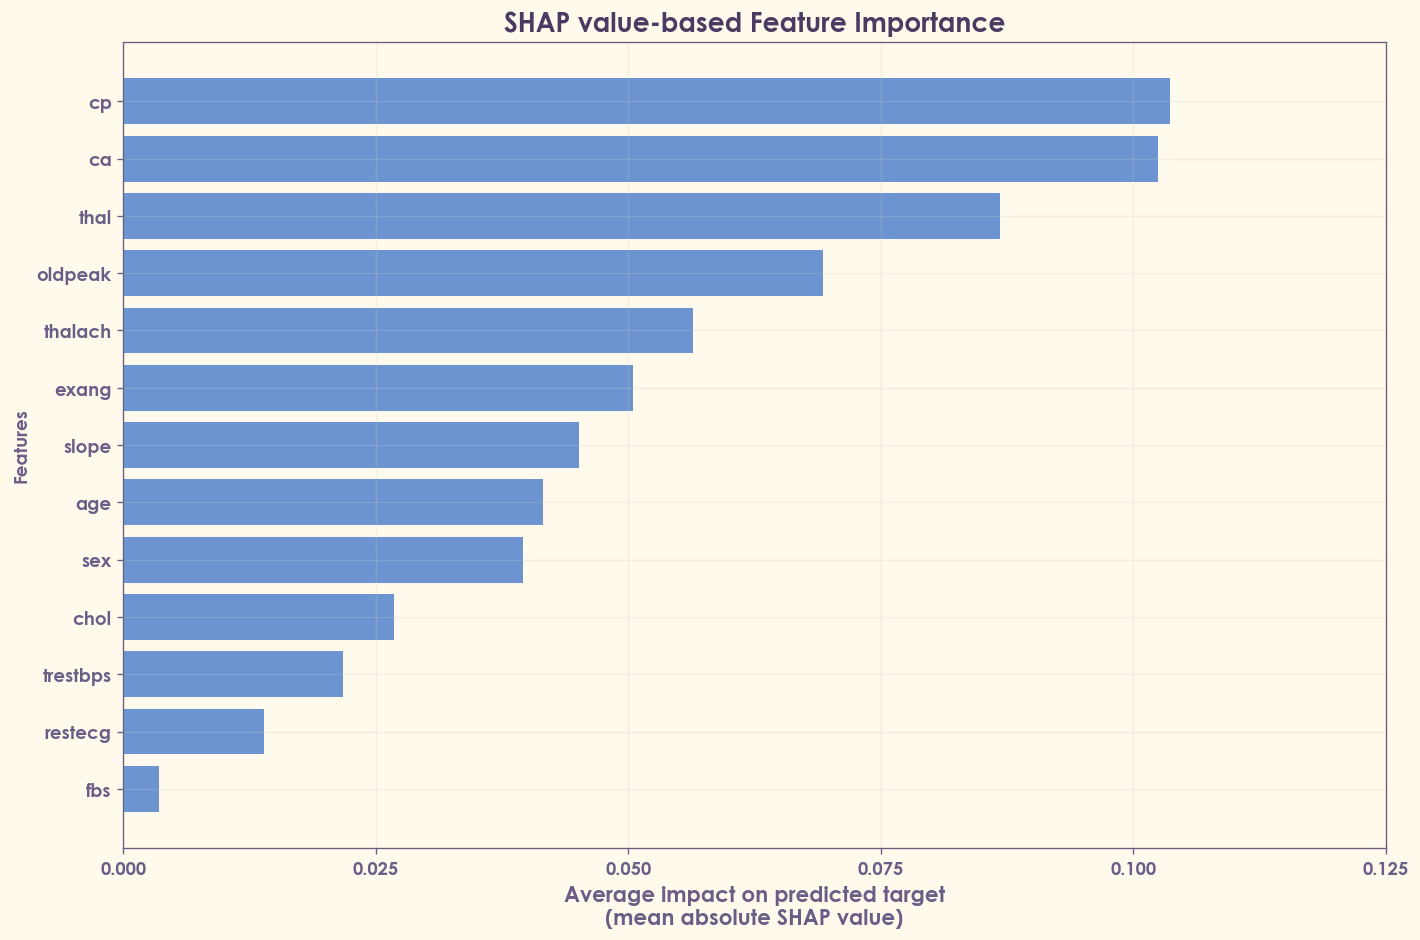

In [17]:
shap_results, shap_vals = SHAP_calc(df=df, features=features)

Given Figure 2 in the original paper.
<img src="../contents/figures/originals/Figure2.jpg" width=70%>